# This notebook is to illustrate how the model systematic uncertainty ($\sigma_{\rm sys}$) affect the weights of observed mode frequencies in the fitting procedure and why a weighting factor ($w$) is required.

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import glob
from scipy.optimize import curve_fit
import re
import math
import os
import matplotlib.pyplot #
from astropy.io import ascii

# The lines below are specific to the notebook format
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
matplotlib.rcParams.update(params)
plt = matplotlib.pyplot


# First let us see how the uncertainty distribution looks like

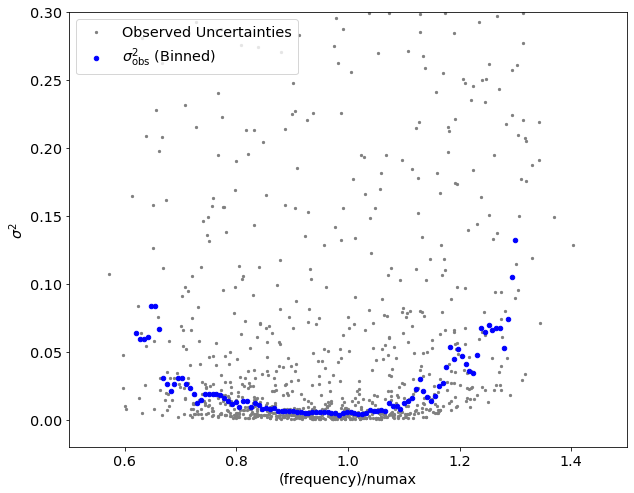

In [4]:
modes = ascii.read('mode_parameters.csv')
modes = modes[modes['lnk']>1]

#plt.scatter((modes['lnk']), modes['fc_err'])

stars = ascii.read('final_subgiants1.csv')

kepid = np.unique(modes['keplerid'])

modes_l0 = np.array([0])
modes_l1 = np.array([0])
modes_l2 = np.array([0])

modes_l0_e = np.array([0])
modes_l1_e = np.array([0])
modes_l2_e = np.array([0])

for tstar in stars:
    numax, dnu = tstar['numax'], tstar['Delta_nu']
    idx = modes['keplerid']==tstar['kic']
    tmodes = modes[idx]
    l0 = tmodes['l']==0
    l1 = tmodes['l']==1
    l2 = tmodes['l']==2
    
    modes_l0 = np.concatenate((modes_l0, tmodes['fc'][l0]/numax))
    modes_l1 = np.concatenate((modes_l1, tmodes['fc'][l1]/numax))
    modes_l2 = np.concatenate((modes_l2, tmodes['fc'][l2]/numax))

    modes_l0_e = np.concatenate((modes_l0_e, tmodes['fc_err'][l0]))
    modes_l1_e = np.concatenate((modes_l1_e, tmodes['fc_err'][l1]))
    modes_l2_e = np.concatenate((modes_l2_e, tmodes['fc_err'][l2]))  
    
modes = np.concatenate( (modes_l0, modes_l1, modes_l2) )
modes_e = np.concatenate( (modes_l0_e, modes_l1_e, modes_l2_e) )


modes_es = (modes_e**2.0 + 0.75**2.0)**0.5


modes_e = modes_e**2.0#/np.median(modes_e**2.0)
modes_es =  modes_e**2.0#/np.median(modes_e**2.0)

plt.scatter(modes, modes_e, c = 'grey', s = 5, label = 'Observed Uncertainties')

xbin = np.linspace(0.62,1.3,100)
binsize = 0.03
ybin = np.full(len(xbin),0.0)
ybin2 = np.full(len(xbin),0.0)
ybinb = np.full(len(xbin),0.0)
ybinb2 = np.full(len(xbin),0.0)


for i in range(len(xbin)): 
    condition = (np.abs(modes - xbin[i]) <= 0.5*binsize) & (modes_e < 0.5**2.0)
    ybin[i] = np.median(modes_e[condition])
    ybin2[i] = 0.75**2.0 + ybin[i]


plt.scatter(xbin, ybin, c = 'b',s = 20, label = r'$\sigma^{2}_{\rm obs}$ (Binned)')
#plt.scatter(xbin, ybin2, c = 'r', label = r'$\sigma^{2}_{\rm obs} + \sigma^{2}_{\rm sys}$ (Binned)')


SS = 0.75*(1.4 - 0.6)/2.0
PP = 2.0


superg = 1.0/np.exp(-((xbin - 1.0)**2.0/SS)**PP)

#plt.scatter(xbin, superg-0.15, c = 'g', s = 20, label = 'super guassian')

plt.xlabel('(frequency)/numax')
plt.ylabel(r'$\sigma^{2}$')
plt.xlim(0.5,1.5)
plt.ylim(-0.02,0.3)
plt.legend()

# The above plot illustrates the distribution of frequency uncertainties of 36 Kepler subgiants. At it can be seen that the model systematic uncertainty (here we applied the median value of $\sigma_{\rm sys}$ = 0.75) is much larger most observed uncertainties. As a result, the weights of mode frequencies become much more uniform (the weights can be derived by $\sigma^{2}/\sigma^{2}_{min}$). It leads to an issue that poor measured modes could harm the fitting to some extent.

# Now let us take one star KIC 2991448 to investigate the issue.  

In [5]:
dr = '/Users/litz/Documents/GitHub/kepler_sg_paper/'
datadr = '/Users/litz/Documents/GitHub/data/kepler-sg-grid/'
filename = dr + 'mode_parameters.csv'
df = pd.read_csv(filename)

[11.498946 12.499818 13.49298  14.467642 15.455442 16.463172 17.474446
 18.482892 19.493834 20.50738  21.52777 ]


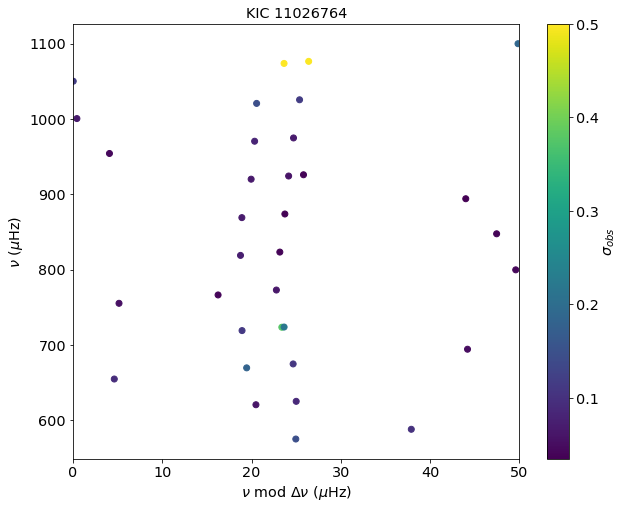

In [867]:
KIC = 11026764
obs_teff = 5639.0
obs_teff_e = 100.0
obs_feh = 0.04
obs_feh_e = 0.10
obs_deltanu = 50.0
obs_deltanu_e = obs_deltanu*0.05
obs_numax = 850.0
obs_numax_e = obs_numax*0.05

obs_nu0 = df['fc'][(df['keplerid'] == KIC) & (df['l'] == 0) & (df['fc'] <= 1110)].to_numpy()
obs_nu0_e = df['fc_err'][(df['keplerid'] == KIC) & (df['l'] == 0) & (df['fc'] <= 1110)].to_numpy()
n0 = obs_nu0/obs_deltanu

print(n0)

obs_nu1 = df['fc'][(df['keplerid'] == KIC) & (df['l'] == 1) & (df['fc'] <= 1110)].to_numpy()
obs_nu1_e = df['fc_err'][(df['keplerid'] == KIC) & (df['l'] == 1) & (df['fc'] <= 1110)].to_numpy()

obs_nu2 = df['fc'][(df['keplerid'] == KIC) & (df['l'] == 2) & (df['fc'] <= 1110)].to_numpy()
obs_nu2_e = df['fc_err'][(df['keplerid'] == KIC) & (df['l'] == 2) & (df['fc'] <= 1110)].to_numpy()

obs_nu0_es = (obs_nu0_e**2 + 0.2**2)**0.5
obs_nu1_es = (obs_nu1_e**2 + 0.5**2)**0.5
obs_nu2_es = (obs_nu2_e**2 + 0.2**2)**0.5

obs_nu = np.concatenate((obs_nu0, obs_nu1, obs_nu2))
obs_nu_e = np.concatenate((obs_nu0_e, obs_nu1_e, obs_nu2_e))
obs_nu_es = np.concatenate((obs_nu0_es, obs_nu1_es, obs_nu2_es))


#plt.scatter((obs_nu0 % obs_deltanu), obs_nu0, c = obs_nu0_e/np.median(obs_nu0_e), marker='o')
#plt.scatter((obs_nu1 % obs_deltanu), obs_nu1, c = obs_nu1_e/np.median(obs_nu1_e),marker='^')
#plt.scatter((obs_nu2 % obs_deltanu), obs_nu2, c = obs_nu2_e/np.median(obs_nu2_e),marker='s')

e_c = obs_nu_e
e_c[e_c>=0.8] = 0.5

cp = plt.scatter((obs_nu % obs_deltanu), obs_nu, c = e_c, marker='o')
plt.title('KIC ' + str(KIC))
plt.xlim([0.0, obs_deltanu])
plt.xlabel(r'$\nu$ mod $\Delta\nu$ ($\mu$Hz)')
plt.ylabel(r'$\nu$ ($\mu$Hz)')
cc = plt.colorbar(cp)
cc.set_label(r'$\sigma_{obs}$')



# Echelle diagram of KIC 2991448. Colorcode indicates observed frequency uncertainties. 

In [984]:
#fehs = ['m20/','m15/','m10/','m05/','p00/','p05/','p10/','p15/','p20/','p25/']
fehs = ['m10/','m05/','p00/','p05/','p10/','p15/','p20/']
masses = ['m1.1*/','m1.2*/']

In [985]:
allfiles = []
mms = []
zx = []
for feh in fehs:
    for mass in masses: 
        folder = feh + mass
        ff = glob.glob(datadr + folder)
        files = glob.glob(datadr + folder + "*.osc")
        allfiles = allfiles + files
        zx = zx + [feh]*len(files)

In [986]:
starset = pd.DataFrame(data = allfiles, columns = ['filename'])
starset['mass'] = starset['filename'].str.extract(r'(\d+.\d+)').astype('float')
starset['feh'] = zx
starset['delta_nu'] = -999.0
starset['surf_a'] = -999.0
starset['surf_b'] = -999.0
starset['sc_method'] = 'N/A'
starset['lk_0'] = -999.0
starset['lk_1'] = -999.0
starset['lk_2'] = -999.0
starset['lkall'] = -999.0
starset['wlkall'] = -999.0
starset

,filename,mass,feh,delta_nu,surf_a,surf_b,sc_method,lk_0,lk_1,lk_2,lkall,wlkall
0,/Users/litz/Documents/GitHub/data/kepler-sg-gr...,1.19,m10/,-999.0,-999.0,-999.0,N/A,-999.0,-999.0,-999.0,-999.0,-999.0
1,/Users/litz/Documents/GitHub/data/kepler-sg-gr...,1.19,m10/,-999.0,-999.0,-999.0,N/A,-999.0,-999.0,-999.0,-999.0,-999.0
2,/Users/litz/Documents/GitHub/data/kepler-sg-gr...,1.19,m10/,-999.0,-999.0,-999.0,N/A,-999.0,-999.0,-999.0,-999.0,-999.0
3,/Users/litz/Documents/GitHub/data/kepler-sg-gr...,1.19,m10/,-999.0,-999.0,-999.0,N/A,-999.0,-999.0,-999.0,-999.0,-999.0
4,/Users/litz/Documents/GitHub/data/kepler-sg-gr...,1.19,m10/,-999.0,-999.0,-999.0,N/A,-999.0,-999.0,-999.0,-999.0,-999.0
...,...,...,...,...,...,...,...,...,...,...,...,...
125969,/Users/litz/Documents/GitHub/data/kepler-sg-gr...,1.26,p20/,-999.0,-999.0,-999.0,N/A,-999.0,-999.0,-999.0,-999.0,-999.0
125970,/Users/litz/Documents/GitHub/data/kepler-sg-gr...,1.26,p20/,-999.0,-999.0,-999.0,N/A,-999.0,-999.0,-999.0,-999.0,-999.0
125971,/Users/litz/Documents/GitHub/data/kepler-sg-gr...,1.26,p20/,-999.0,-999.0,-999.0,N/A,-999.0,-999.0,-999.0,-999.0,-999.0
125972,/Users/litz/Documents/GitHub/data/kepler-sg-gr...,1.26,p20/,-999.0,-999.0,-999.0,N/A,-999.0,-999.0,-999.0,-999.0,-999.0


In [987]:
def linear(x, a, b):
    return a * x + b

def ball_two_term(X, a1, a3):
    nu0, nu, inertia = X
    return nu0 + (a1*nu**(-1.0) + a3*nu**3.0)/inertia
    
    
def kb95(X, a, b):
    x1, x2 = X
    return x1 - a*x2**b

def surface_correction(obs_freq, obs_freq_e, model_freq, model_inertia, nu_max, sc_method):
    if (sc_method == 'kb95'):
        #kb 95 nu_obs - nu_model = a*(nu_obs/nu_max)**b        
        popt, pcov = curve_fit(kb95, (obs_freq, obs_freq/nu_max), model_freq)
        a, b = popt
        a_e, b_e = pcov
    if (sc_method == 'bg2'):
        #Ball&Gizon 2 terms: obs - model = (a1*(nu/nu_ac)**(-1) + a3*(nu/nu_ac)**(3))/inertia
        # model = obs - (a1*(nu/nu_ac)**(-1) + a3*(nu/nu_ac)**(3))/inertia
        popt, pcov = curve_fit(ball_two_term, (model_freq, model_freq/1.6/nu_max, model_inertia), obs_freq, sigma = obs_freq_e)
        a, b = popt
        a_e, b_e = pcov
        model_freq_c = ball_two_term((model_freq,model_freq/1.6/nu_max, model_inertia), a, b)
    return a, b, model_freq_c  

def correct_sc(obs_freq, mode_freq, nu_max, sc_method, a, b):
    if (sc_method == 'kb95'):
        new_mode_freq = mode_freq + a*(mode_freq/nu_max)**b
    return new_mode_freq

def seismo_lk(obs_freq,obs_freq_e,mode_freq, n):
    chi2 = np.mean(1.0/n*((obs_freq - mode_freq)**2.0/2.0/obs_freq_e**2.0))
    lk = math.exp(0.0 - chi2)
    return lk

def chi2(model, obs, obs_e):
    chi2 = (model - obs)**2.0/2.0/obs_e**2.0
    return chi2

def fit_two_sets(obs, obs_e, model, model_x = None):
    find_model = np.full(len(obs), 0.0)
    find_model_x = np.full(len(obs), 0.0)
    chi2_obs = np.full(len(obs), 9999.0)
    for i in range(len(obs)):
        nuse = np.argmin(np.abs(model - obs[i]))
        find_model[i] = model[nuse]
        find_model_x[i] = model_x[nuse]
        chi2_obs[i] = chi2(model[nuse], obs[i], obs_e[i])
    return find_model, find_model_x, chi2_obs

def prob(para, lk, start, end, binsize, shift):
    n = int((end - start + shift)/binsize)
    x = np.zeros(n)
    y = np.zeros(n)
    for i in range(n):
        x[i] = start + shift + i*binsize + 0.5*binsize
        yindex = np.where((para >= (start + shift + i*binsize)) &
                          (para < (start + shift + (i+1)*binsize))
                         )
        yyy = yindex[0]
        if (len(yyy) > 0):
            y[i] = np.max(lk[yyy])
    return x, y

In [988]:
t = 0
for index, row in starset.iterrows():
    oscfile = row['filename']
    if os.path.isfile(oscfile):
        model_l, model_np, model_ng, model_nu,model_E_norm = np.loadtxt(oscfile, skiprows=6, usecols=(0,1,2,3,5), unpack=True)
        fitn0 = np.array(model_np[(model_l == 0) & (model_nu >= 0.5*obs_numax) & (model_nu <= 0.95*obs_numax)])
        fitnu0 = np.array(model_nu[(model_l == 0) & (model_nu >= 0.5*obs_numax) & (model_nu <= 0.95*obs_numax)])
        
        if len(fitn0)>=3:
            popt, pcov = curve_fit(linear, fitn0, fitnu0)
            starset.loc[index, ('delta_nu')] = popt[0]
            t = t+1
        #get_model_delta_nu()        
        #model_nu0 = np.array(model_nu[(model_l == 0)])
        #model_nu_c = correct_sc(obs_nu0, model_nu0, obs_numax, 'kb95', row['surf_a'], row['surf_b'])
        #model_nu_f, starset_seismo['lk_l1'][index] = fit_two_sets(obs_nu1, obs_nu1_e, model_nu1_c)
t

123630

In [999]:
idex = (starset['delta_nu'] >= 0.98*obs_deltanu) & (starset['delta_nu'] <= 1.02*obs_deltanu)
seismoset = starset[idex]
seismoset.index = range(len(seismoset))
len(seismoset)

1603

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


(1.0, 1.3)

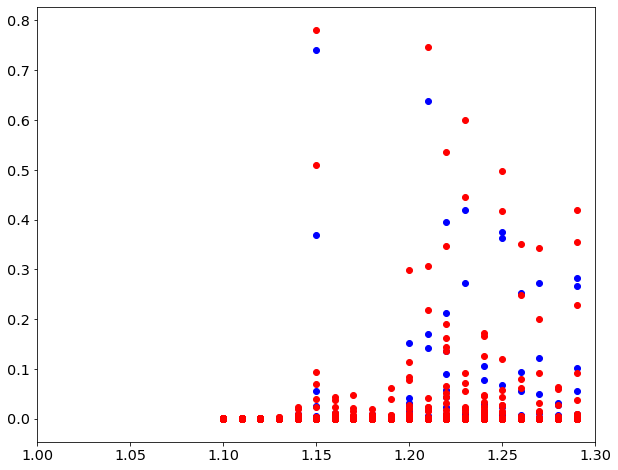

In [1023]:
obs_nu0_es = (obs_nu0_e**2 + 0.5**2)**0.5
obs_nu1_es = (obs_nu1_e**2 + 0.8**2)**0.5
obs_nu2_es = (obs_nu2_e**2 + 0.60**2)**0.5
obs_nu_es = np.concatenate((obs_nu0_es, obs_nu1_es, obs_nu2_es))

t = 0
for index, row in seismoset.iterrows():
    oscfile = row['filename']
    if os.path.isfile(oscfile):
        model_l, model_np, model_ng, model_nu,model_E_norm = np.loadtxt(oscfile, skiprows=6, usecols=(0,1,2,3,5), unpack=True)
        
        model_nu0 = np.array(model_nu[(model_l == 0)])
        model_E0 = np.array(model_E_norm[(model_l == 0)])
        model_nu1 = np.array(model_nu[(model_l == 1)])
        model_E1 = np.array(model_E_norm[(model_l == 1)])
        model_nu2 = np.array(model_nu[(model_l == 2)])
        model_E2 = np.array(model_E_norm[(model_l == 2)])
        
        find_nu0, find_E0, lk0 = fit_two_sets(obs_nu0, obs_nu0_es, model_nu0, model_E0)
        find_nu1, find_E1, lk1 = fit_two_sets(obs_nu1, obs_nu1_es, model_nu1, model_E1)
        find_nu2, find_E2, lk2 = fit_two_sets(obs_nu2, obs_nu2_es, model_nu2, model_E2)

        find_nu = np.concatenate((find_nu0, find_nu1, find_nu2))
        find_E = np.concatenate((find_E0, find_E1, find_E2))
            
        a1, a3, find_nu_c = surface_correction(obs_nu, obs_nu_es, find_nu, find_E, obs_numax, 'bg2')
        
        tt0, tt1, lkall = fit_two_sets(obs_nu, obs_nu_es, find_nu_c, find_E)
        
        SS = 0.67*(np.max(obs_nu) - np.min(obs_nu))/2.0
        PP = 2.0

        wi = np.exp(-((obs_nu - obs_numax)**2.0/2.0/SS**2.0)**PP)
                
        seismoset.loc[index, ('surf_a')] = a1
        seismoset.loc[index, ('surf_b')] = a3
        seismoset.loc[index, ('lk')] = np.exp(-np.mean(lkall))
        
        seismoset.loc[index, ('lk_0')] = 0.0
        seismoset.loc[index, ('lk_1')] = 0.0
        seismoset.loc[index, ('lk_2')] = np.exp(-np.mean(wi*lkall))
        
        seismoset.loc[index, ('sc_method')] = 'bg2'

plt.scatter(seismoset['mass'],seismoset['lk'], c = 'b')
plt.scatter(seismoset['mass'],seismoset['lk_2'],c = 'r')
plt.xlim([1.0,1.30])

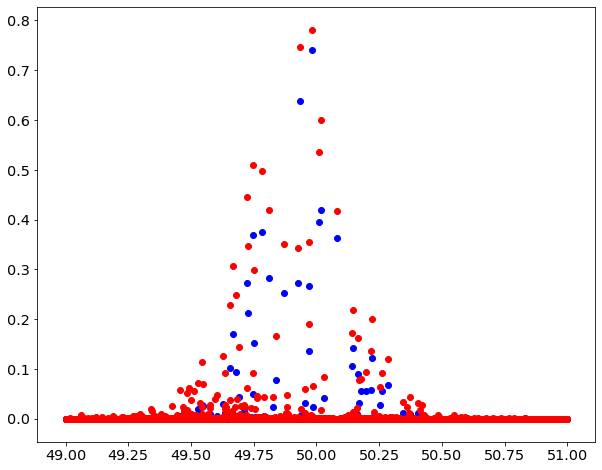

In [1024]:
plt.scatter(seismoset['delta_nu'],seismoset['lk'], c = 'b')
plt.scatter(seismoset['delta_nu'],seismoset['lk_2'],c = 'r')

In [1025]:
goodset = seismoset[(seismoset['lk']>0.0001) & (seismoset['mass']<=1.28) & (seismoset['mass']>=1.10)]
goodset.index = range(len(goodset))
#goodset['lk_2'][np.argmax(goodset['lk_2'])] = 0.2
#goodset['lk'][np.argmax(goodset['lk'])] = 0.25

print(len(goodset))

#plt.scatter(goodset['mass'],goodset['lk'], c = 'b', marker = 'x', label = 'Unweighted $\chi^{2}_{seismo}$')
#plt.scatter(goodset['mass'],goodset['lk_2'],c = 'r', marker = 'o', label = 'Weighted $\chi^{2}_{seismo}$')
#plt.xlim([1.10,1.30])
#plt.ylabel(r'Seismic Likelihood ($e^{-\chi^{2}_{seismo}}$)')
#plt.xlabel(r'Mass (M$_{\odot}$)')
#plt.legend()
#plt.title('Top 50 good-fitting models for KIC'+ str(KIC))

231


[Text(0, 0, '0.0'),
 Text(0, 0, '0.2'),
 Text(0, 0, '0.4'),
 Text(0, 0, '0.6'),
 Text(0, 0, '0.8'),
 Text(0, 0, '1.0')]

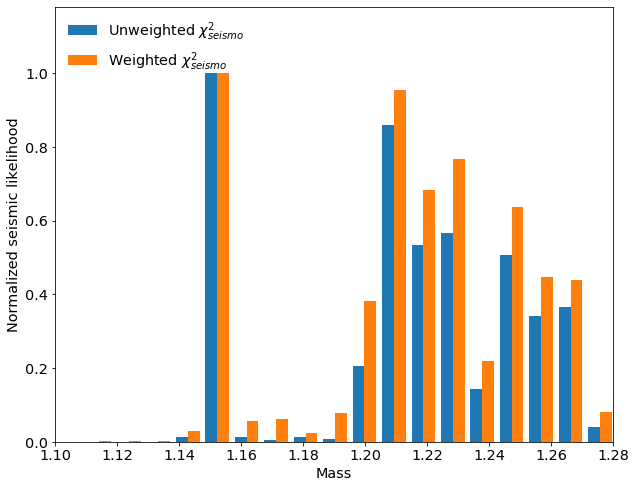

In [1026]:
px1, py1 = prob(goodset['mass'], goodset['lk'], 1.095, 1.295, 0.01, 0.0)
px2, py2 = prob(goodset['mass'], goodset['lk_2'], 1.095, 1.295, 0.01, 0.0)

#py1[3] = 0.9*py1[3]
#py2[3] = 0.9*py2[3]

pxs1 = []
pys1 = []
pxs2 = []
pys2 = []
for i in range(len(px1)):
    nn1 = int(py1[i]/np.max(py1)*1000)
    nn2 = int(py2[i]/np.max(py2)*1000)
    pxs1 = pxs1 + [px1[i]]*nn1
    pxs2 = pxs2 + [px2[i]]*nn2

#plt.scatter(px1, py1, label='Unweighted $\chi^{2}_{seismo}$')
#plt.scatter(px2, py2, label='Weighted $\chi^{2}_{seismo}$')
fig, ax = plt.subplots()
n, bins, patches = ax.hist([pxs1, pxs2], bins = 20, range=[1.10,1.29], label=['Unweighted $\chi^{2}_{seismo}$', 'Weighted $\chi^{2}_{seismo}$'])
plt.legend(loc='upper left',frameon=False)

#plt.scatter(px1, py1/np.max(py1), c = 'b',label='unweighted')
#plt.plot(px1, py1/np.max(py1), c = 'b',label='unweighted')
#plt.scatter(px2, py2/np.max(py2), c = 'r',label='weighted')
#plt.plot(px2, py2/np.max(py2), c = 'r',label='weighted')


#plt.legend()

#plt.title(r' ')
plt.xlabel('Mass')
plt.ylabel('Normalized seismic likelihood')
plt.ylim(0.0,1180)
plt.xlim(1.10,1.28)
ax.set_xticks([1.10,1.12, 1.14,1.16,1.18,1.20,1.22,1.24,1.26,1.28])
ax.set_yticks([0,200,400,600,800,1000])
ax.set_yticklabels(['0.0','0.2','0.4','0.6','0.8','1.0'])
#popt,pcov = curve_fit(gaus,px,py)
#plt.plot(px,'ro:',label='fit')

[Text(0, 0, '0.0'),
 Text(0, 0, '0.2'),
 Text(0, 0, '0.4'),
 Text(0, 0, '0.6'),
 Text(0, 0, '0.8'),
 Text(0, 0, '1.0')]

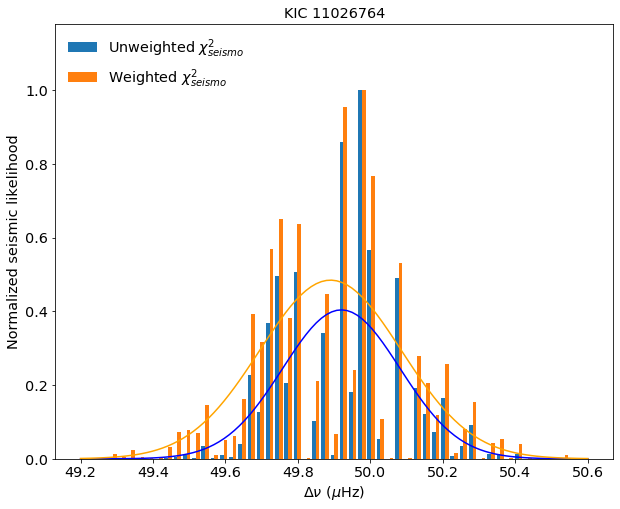

In [1027]:
start = 49.2
end = 50.6
size = 0.025


nbins = int((end - start)/size)

px1, py1 = prob(goodset['delta_nu'], goodset['lk'], start, end, size, 0.0)
px2, py2 = prob(goodset['delta_nu'], goodset['lk_2'], start, end, size, 0.0)


#py1[3] = 0.9*py1[3]
#py2[3] = 0.9*py2[3]

pxs1 = []
pys1 = []
pxs2 = []
pys2 = []
for i in range(len(px1)):
    nn1 = int(py1[i]/np.max(py1)*1000)
    nn2 = int(py2[i]/np.max(py2)*1000)
    pxs1 = pxs1 + [px1[i]]*nn1
    pxs2 = pxs2 + [px2[i]]*nn2

#plt.scatter(px1, py1, label='Unweighted $\chi^{2}_{seismo}$')
#plt.scatter(px2, py2, label='Weighted $\chi^{2}_{seismo}$')
fig, ax = plt.subplots()
n, bins, patches = ax.hist([pxs1, pxs2], bins = nbins, range=[start, end], label=['Unweighted $\chi^{2}_{seismo}$', 'Weighted $\chi^{2}_{seismo}$'])
plt.legend(loc='upper left',frameon=False)

#plt.scatter(px1, py1/np.max(py1), c = 'b',label='unweighted')
#plt.plot(px1, py1/np.max(py1), c = 'b',label='unweighted')
#plt.scatter(px2, py2/np.max(py2), c = 'r',label='weighted')
#plt.plot(px2, py2/np.max(py2), c = 'r',label='weighted')

XX = np.array(bins[0:(len(bins)-1)] + 0.5*size)
YY = n[0]
def gaussian_function(x, amp, mu, sigma):
    y = amp*1.0/sigma/(2.0*3.14159)**0.5*np.exp(-0.5*((x-mu)/sigma)**2.0)  #amp*1.0/sigma/(2.0*3.14159)**0.5*np.exp(-0.5*((x-mu)/sigma)**2.0)
    return y

popt, pcov = curve_fit(gaussian_function, XX, YY, p0=[200,obs_deltanu, 0.2])
amp, mu, sigma = popt

gx = np.linspace(start, end, 100)
gy = gaussian_function(gx, amp, mu, sigma)
plt.plot(gx, gy, 'b')


XX = np.array(bins[0:(len(bins)-1)] + 0.5*size)
YY = n[1]
popt, pcov = curve_fit(gaussian_function, XX, YY, p0=[200,obs_deltanu, 0.2])
amp, mu, sigma = popt

gx = np.linspace(start, end, 100)
gy = gaussian_function(gx, amp, mu, sigma)
plt.plot(gx, gy, 'orange')


#plt.legend()

#plt.title(r' ')
plt.xlabel(r'$\Delta\nu$ ($\mu$Hz)')
plt.ylabel('Normalized seismic likelihood')
plt.ylim(0.0,1180)
ax.set_title('KIC '+ str(KIC))
#plt.xlim(0.9,1.28)
#ax.set_xticks([1.10,1.12, 1.14,1.16,1.18,1.20,1.22,1.24,1.26,1.28])
ax.set_yticks([0,200,400,600,800,1000])
ax.set_yticklabels(['0.0','0.2','0.4','0.6','0.8','1.0'])
#popt,pcov = curve_fit(gaus,px,py)
#plt.plot(px,'ro:',label='fit')

In [1028]:
nbest = np.argmax(seismoset['lk'])
nbest2 = np.argmax(seismoset['lk_2']) 
subdf1 = goodset[((goodset['lk_2']/np.max(goodset['lk_2']))>0.1) ]
subdf1.index = range(len(subdf1))

30

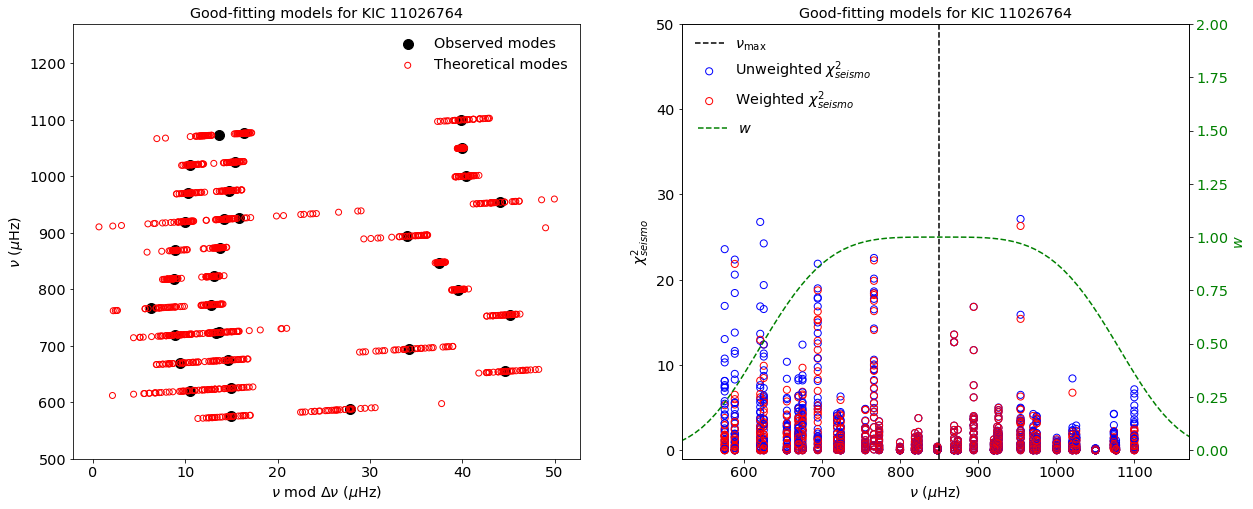

In [1030]:
#plt.scatter(obs_nu % obs_deltanu, obs_nu, c = 'k')

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,8))

ax1.scatter((obs_nu - 10) % obs_deltanu, obs_nu, c = 'k', marker = 'o', label = 'Observed modes',s = 100)

t = 0
for index, row in subdf1.iterrows():
    oscfile = row['filename']
    if os.path.isfile(oscfile):
        model_l, model_np, model_ng, model_nu,model_E_norm = np.loadtxt(oscfile, skiprows=6, usecols=(0,1,2,3,5), unpack=True)
        model_nu0 = np.array(model_nu[(model_l == 0)])
        model_E0 = np.array(model_E_norm[(model_l == 0)])
        model_nu1 = np.array(model_nu[(model_l == 1)])
        model_E1 = np.array(model_E_norm[(model_l == 1)])
        model_nu2 = np.array(model_nu[(model_l == 2)])
        model_E2 = np.array(model_E_norm[(model_l == 2)])
        
        find_nu0, find_E0, lk0 = fit_two_sets(obs_nu0, obs_nu0_es, model_nu0, model_E0)
        find_nu1, find_E1, lk1 = fit_two_sets(obs_nu1, obs_nu1_es, model_nu1, model_E1)
        find_nu2, find_E2, lk2 = fit_two_sets(obs_nu2, obs_nu2_es, model_nu2, model_E2)

        find_nu = np.concatenate((find_nu0, find_nu1, find_nu2))
        find_E = np.concatenate((find_E0, find_E1, find_E2))
    
        a1, a3, find_nu_c = surface_correction(obs_nu, obs_nu_es, find_nu, find_E, obs_numax, 'bg2')
        
        tt0, tt1, lk = fit_two_sets(obs_nu, obs_nu_es, find_nu_c, find_E)
        lk1 = lk
        
        wi = np.exp(-((obs_nu - obs_numax)**2.0/2.0/SS**2.0)**PP)
        lk2 = wi*lk
        
        #plt.scatter(find_nu_c % obs_deltanu, find_nu_c, c = 'b',s = 10)
        if index == 1:
            ax1.scatter((find_nu_c-10) % obs_deltanu, find_nu_c, facecolors='none', edgecolors='r', marker = 'o', label = 'Theoretical modes')
            ax2.scatter(obs_nu, lk1, s = 50, facecolors='none', edgecolors='b', marker = 'o', label = 'Unweighted $\chi^{2}_{seismo}$')
            ax2.scatter(obs_nu, lk2,s = 50, facecolors='none', edgecolors='r', marker = 'o', label = 'Weighted $\chi^{2}_{seismo}$')
            ddd = np.abs(find_nu_c - obs_nu)
        else:
            ax1.scatter((find_nu_c-10) % obs_deltanu, find_nu_c, facecolors='none', edgecolors='r', marker = 'o')
            ax2.scatter(obs_nu, lk1, s = 50, facecolors='none', edgecolors='b', marker = 'o')
            ax2.scatter(obs_nu, lk2, s = 50, facecolors='none', edgecolors='r', marker = 'o')

        t = t + 1
        
        #plt.scatter(find_nu_c % obs_deltanu, find_nu_c, c = 'r',s = 10)
        #plt.scatter(obs_nu, lk2, c = 'r', s = 10)

xxx = np.linspace(500,1400, 100)
yyy = np.exp(-((xxx - obs_numax)**2.0/2.0/SS**2.0)**PP)

ax3 = ax2.twinx()  # instantiate a second axes that shares the same x-axis

color = 'green'
ax3.set_ylabel(r'$w$', color=color)  # we already handled the x-label with ax1
ax3.plot(xxx, yyy, 'g--', label = r'$w$', color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_ylim([-0.04,2.0])
        
ax2.plot([obs_numax, obs_numax], [-1.0,100], 'k--', label = r'$\nu_{\rm max}$')        
ax1.set_xlabel(r'$\nu$ mod $\Delta\nu$ ($\mu$Hz)')
ax1.set_ylabel(r'$\nu$ ($\mu$Hz)')
ax1.set_ylim([500,1270])
ax1.set_title('Good-fitting models for KIC ' + str(KIC))
ax1.legend(loc='best',frameon=False)
ax2.set_xlabel(r'$\nu$ ($\mu$Hz)')
ax2.set_ylabel(r'$\chi^{2}_{seismo}$')
ax2.set_title('Good-fitting models for KIC ' + str(KIC))
ax2.set_ylim([-1.,50])
ax2.set_xlim([520,1170])
ax2.legend(loc='upper left',frameon=False)
ax3.legend(loc=[0.02,0.73],frameon=False)
t

In [998]:
print(np.median(ddd))

0.2634108443477885


Text(0, 0.5, '$\\sigma^{2}$/$\\sigma^{2}_{\\rm median}$')

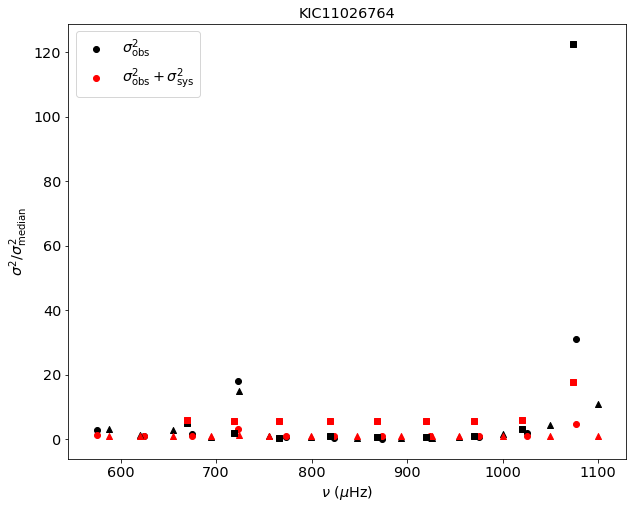

In [965]:
#add model systematical error


plt.scatter(obs_nu0, obs_nu0_e**2/np.median(obs_nu0_e)**2,  c = 'k',marker='o', label = r'$\sigma^{2}_{\rm obs}$')
plt.scatter(obs_nu0, obs_nu0_es**2/np.median(obs_nu0_es)**2,  c = 'r',marker='o', label = r'$\sigma^{2}_{\rm obs} + \sigma^{2}_{\rm sys}$')
plt.scatter(obs_nu1, obs_nu1_e**2/np.median(obs_nu1_e)**2,  c = 'k',marker='^')
plt.scatter(obs_nu1, obs_nu1_es**2/np.median(obs_nu1_es)**2,  c = 'r',marker='^')
plt.scatter(obs_nu2, obs_nu2_e**2/np.median(obs_nu2_e)**2,  c = 'k',marker='s')
plt.scatter(obs_nu2, obs_nu2_es**2/np.median(obs_nu0_es)**2,  c = 'r',marker='s')
plt.legend()
plt.yscale('linear')
plt.title('KIC' + str(KIC))
plt.xlabel(r'$\nu$ ($\mu$Hz)')
plt.ylabel(r'$\sigma^{2}$/$\sigma^{2}_{\rm median}$')

# The above plot is to illustrate the change of relative weights (derived by $\sigma^{2}$/$\sigma^{2}_{\rm min}$) of observed modes when a model systematical uncertainty ($\sigma_{\rm sys}$) is applied. At it can be seen that, the weights become much more uniform because  $\sigma_{\rm sys}$ dominates the term $\sigma^{2}_{\rm obs} + \sigma^{2}_{\rm sys}$. The relatively uniform weights lead to an issue that poor measured modes. 

# Now let us take one star KIC 2991448 to investigate the issue.  

In [190]:
(1165+549+14275+2399+16734+5127+4882+2057)

47188

In [342]:
SS = 0.75*(np.max(obs_nu) - np.min(obs_nu))/2.0
PP = 2.0

wi = 1.0/np.exp(-((obs_nu - obs_numax)**2.0/SS**2.0)**PP)
wi

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in true_divide
  after removing the cwd from sys.path.


array([            inf,             inf,             inf, 1.48953698e+233,
       1.00632914e+000, 5.14240159e+144,             inf,             inf,
                   inf,             inf,             inf,             inf,
                   inf, 7.02993994e+019, 7.91869332e+004,             inf,
                   inf,             inf,             inf,             inf,
       1.19987109e+000, 4.23461107e+099,             inf,             inf])

In [359]:
wi = 1.0/np.exp(-((obs_nu - obs_numax)**2.0/2.0/SS**2.0)**PP)

In [361]:
wi/np.sum(wi)

array([0.07516461, 0.04278827, 0.03429834, 0.03252881, 0.03239952,
       0.0324797 , 0.03390277, 0.04114626, 0.12563137, 0.05551558,
       0.03826186, 0.03396472, 0.03287986, 0.0324105 , 0.03240222,
       0.03278685, 0.03597018, 0.04948008, 0.03479151, 0.03257676,
       0.03239956, 0.0324547 , 0.03369827, 0.0400677 ])

In [ ]:
(51.4/135.1)**2.0*2.06**3.0